# Stochastic Processes Problem Set – Modeling Stock Price Movements

## Overview
This project models and simulates future stock price movements using stochastic processes. It implements **Geometric Brownian Motion (GBM)** and a
**mean-reverting Ornstein–Uhlenbeck (OU) process on log-prices**, and applies
Monte Carlo simulation to analyze uncertainty and investment risk.

This notebook:
- Collects daily stock prices (Yahoo Finance via `yfinance`) for 1–3 tickers
- Cleans/preprocesses the data (business-day alignment + missing handling)
- Fits two stochastic models:
  - Geometric Brownian Motion (GBM)
  - Ornstein–Uhlenbeck (OU) on log-price (mean-reverting)
- Runs Monte Carlo simulations (default 1000 paths)
- Visualizes simulated paths, terminal distributions, and confidence bands
- Summarizes risk metrics (e.g., probability of loss)

## Requirements
- Python 3.9+
- numpy, pandas, matplotlib
- yfinance

## How to Run (Google Colab)
1. Go to https://colab.research.google.com
2. Upload `stock_stochastic_models_cells.ipynb`.
3. Select **Runtime → Run all**.

## How to Run (Local Jupyter)
1. Install dependencies:
```bash
pip install numpy pandas matplotlib yfinance
```
2. Open Jupyter Notebook or JupyterLab.
3. Open `stock_stochastic_models_cells.ipynb`.
4. Run all cells from top to bottom.

## Usage Notes
- Edit the **User-set parameters** cell to change tickers, horizons, or the number of Monte Carlo simulations.
- The notebook attempts to download historical prices from Yahoo Finance.
- All plots and summaries are displayed inline; no files are saved by default.

## Output Interpretation
- **GBM** reflects trend-following behavior with increasing uncertainty.
- **OU** reflects mean-reverting behavior with tighter confidence bands.
- Probability of loss estimates downside risk relative to the current price.

## Author
Author: Marisa Tania  
Date: 2026-01-18






---



In [75]:
import math
import os
from dataclasses import dataclass
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Configuration

Choose tickers, lookback window, and simulation settings.

In [76]:
# ---- User-set parameters (edit these in-notebook) ----
TICKERS = ["AAPL", "MSFT", "NVDA"]   # choose up to 3
YEARS_LOOKBACK = 1.0                 # at least 1 year
HORIZONS = [30, 60, 180]             # forecast horizons in trading days
N_PATHS = 1000                       # Monte Carlo runs
SEED = 42                            # reproducibility
OUTDIR = "outputs"                   # where to save outputs

TRADING_DAYS = 252


## Utility functions

This section defines:
- Data download + cleaning
- GBM parameter estimation and simulation
- OU parameter estimation and simulation (on log-price)
- Plotting + metrics

In [77]:
def annualize_vol(daily_std: float, trading_days: int = 252) -> float:
    return daily_std * math.sqrt(trading_days)

def annualize_drift(daily_mean: float, trading_days: int = 252) -> float:
    return daily_mean * trading_days


In [78]:
def try_download_prices_yfinance(tickers: List[str], years: float = 1.0) -> pd.DataFrame | None:
    """Return Close dataframe indexed by date. None if download fails."""
    try:
        import yfinance as yf
    except Exception:
        return None

    period = f"{int(max(1, math.ceil(years * 365)))}d"

    try:
        data = yf.download(tickers, period=period, interval="1d", auto_adjust=True, progress=False)
        if data is None or len(data) == 0:
            return None

        # MultiIndex if multiple tickers
        if isinstance(data.columns, pd.MultiIndex):
            close = data["Close"].copy()
        else:
            close = data[["Close"]].copy()
            close.columns = tickers

        close.index = pd.to_datetime(close.index)
        close = close.sort_index()
        return close

    except Exception:
        return None


In [79]:
def make_synthetic_sample(tickers: List[str], n_days: int = 252, seed: int = 7) -> pd.DataFrame:
    """Create a synthetic price series (for offline environments)."""
    rng = np.random.default_rng(seed)
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n_days)

    prices: Dict[str, np.ndarray] = {}
    for t in tickers:
        s0 = float(rng.uniform(80, 220))
        mu = float(rng.uniform(-0.05, 0.25))   # annual drift
        sigma = float(rng.uniform(0.15, 0.45)) # annual vol

        dt = 1 / 252
        z = rng.standard_normal(n_days)
        log_s = np.log(s0) + np.cumsum((mu - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * z)
        s = np.exp(log_s)
        prices[t] = s

    df = pd.DataFrame(prices, index=dates)
    df.index.name = "Date"
    return df


In [80]:
def clean_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """Clean and preprocess: business-day index, forward-fill short gaps."""
    prices = prices.copy()

    # Remove non-positive values
    prices[prices <= 0] = np.nan

    # Business-day alignment
    bidx = pd.bdate_range(prices.index.min(), prices.index.max())
    prices = prices.reindex(bidx)

    # Fill short gaps; then drop remaining
    prices = prices.ffill(limit=3)
    prices = prices.dropna(how="all")
    prices = prices.dropna(axis=0, how="any")  # keep rows consistent across tickers

    prices.index.name = "Date"
    return prices




---



## Data Collection and Preprocessing

### Data Sources
Historical stock price data were collected from **Yahoo Finance** using the
`yfinance` Python library. Yahoo Finance is a widely used and reliable source
for daily equity price data and provides adjusted closing prices that account
for corporate actions such as stock splits and dividends.

The analysis includes multiple large-cap technology stocks (AAPL, MSFT, NVDA),
each with at least one year of daily observations. To ensure full reproducibility,
a synthetic fallback dataset is automatically generated if external data access
is unavailable, allowing the notebook to run end-to-end in offline environments.

### Data Cleaning and Quality Control
Several preprocessing steps were applied to ensure data integrity and consistency
across all assets:

- **Removal of invalid values:** Any non-positive prices were treated as anomalies
  and removed.
- **Business-day alignment:** All price series were reindexed to a common business-day
  calendar to ensure consistent time steps.
- **Missing value handling:** Short gaps (e.g., holidays) were forward-filled using a
  limited window, while remaining missing observations were removed.
- **Cross-asset consistency:** Rows containing missing values for any ticker were
  dropped to maintain aligned observations across all stocks.

After preprocessing, the dataset contained no missing values or structural anomalies,
making it suitable for stochastic modeling and Monte Carlo simulation.

### Final Dataset
The resulting clean dataset consists of synchronized daily closing prices with
uniform time indexing, enabling fair comparison across models and assets and
ensuring that all stochastic simulations are based on high-quality input data.


In [81]:
# ---- Load data once for all tickers ----
tickers = TICKERS[:3]
prices = try_download_prices_yfinance(tickers, years=YEARS_LOOKBACK)

if prices is None:
    print("yfinance download failed — using synthetic sample dataset.")
    prices = make_synthetic_sample(tickers, n_days=int(TRADING_DAYS * max(1.0, YEARS_LOOKBACK)), seed=SEED)

prices = clean_prices(prices)
prices.tail()

Ticker,AAPL,MSFT,NVDA
Date,,,
2026-01-12,260.250000,477.179993,184.940002
2026-01-13,261.049988,470.670013,185.809998
2026-01-14,259.959991,459.380005,183.139999
2026-01-15,258.209991,456.660004,187.050003
2026-01-16,255.529999,459.859985,186.229996




---

## Model Justification

To model and simulate future stock price movements under uncertainty, this analysis
employs two complementary stochastic process models: **Geometric Brownian Motion (GBM)**
and the **Ornstein–Uhlenbeck (OU) process applied to log-prices**. These models are chosen
to capture different theoretical behaviors observed in financial time series.

### Geometric Brownian Motion (GBM)
GBM is the canonical continuous-time model for equity prices and forms the foundation of
the Black–Scholes framework. It assumes that logarithmic returns are independently and
normally distributed with constant drift and volatility. The model ensures strictly
positive prices and captures long-term trend-following behavior.

GBM is appropriate for:
- Modeling growth-oriented equities over short to medium horizons
- Establishing a baseline stochastic benchmark
- Quantifying uncertainty under the efficient market hypothesis

However, GBM does not account for mean reversion, volatility clustering, or sudden jumps,
which limits its realism in certain market regimes.

### Ornstein–Uhlenbeck (OU) Process on Log-Prices
The OU process is a mean-reverting stochastic process. When applied to log-prices, it
allows deviations from a long-run equilibrium level while maintaining continuous dynamics.
This makes it useful for modeling assets or regimes where prices tend to revert toward a
fundamental or equilibrium value.

The OU model is appropriate for:
- Capturing stabilizing forces and pull-back effects in prices
- Modeling temporary deviations from long-term trends
- Providing a contrast to purely trend-driven dynamics

While equity prices are not strictly mean-reverting in levels, applying OU dynamics to
log-prices offers a reasonable approximation for studying medium-term corrective behavior.

### Comparative Rationale
Using both GBM and OU models enables a structured comparison between:
- **Trend-dominated dynamics (GBM)** and **mean-reverting dynamics (OU)**
- Risk profiles under different structural assumptions
- Sensitivity of investment outcomes to model choice

This dual-model approach highlights the importance of model selection in stochastic
forecasting and provides a more comprehensive perspective on uncertainty and downside
risk than relying on a single modeling framework.

## Model: GBM

In [82]:
@dataclass
class GBMParams:
    mu_annual: float
    sigma_annual: float

def fit_gbm_from_prices(price: pd.Series) -> GBMParams:
    r = np.log(price).diff().dropna()
    mu_d = float(r.mean())
    sigma_d = float(r.std(ddof=1))
    return GBMParams(
        mu_annual=annualize_drift(mu_d, TRADING_DAYS),
        sigma_annual=annualize_vol(sigma_d, TRADING_DAYS),
    )

def simulate_gbm_paths(
    s0: float,
    params: GBMParams,
    n_days: int,
    n_paths: int,
    seed: int,
    trading_days: int = 252,
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    dt = 1.0 / trading_days
    z = rng.standard_normal((n_paths, n_days))

    mu = params.mu_annual
    sigma = params.sigma_annual

    increments = (mu - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * z
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack([np.zeros((n_paths, 1)), log_paths])
    return s0 * np.exp(log_paths)


## Model: OU on log-price

In [83]:
@dataclass
class OUParams:
    theta_annual: float
    mu: float
    sigma_annual: float

def fit_ou_on_logprice(price: pd.Series, trading_days: int = 252) -> OUParams:
    x = np.log(price).values
    x0, x1 = x[:-1], x[1:]

    # OLS: x1 = a + b*x0 + e
    X = np.column_stack([np.ones_like(x0), x0])
    beta, *_ = np.linalg.lstsq(X, x1, rcond=None)
    a_hat, b_hat = float(beta[0]), float(beta[1])

    b_hat = min(max(b_hat, 1e-6), 0.999999)

    dt = 1.0 / trading_days
    theta = -math.log(b_hat) / dt
    mu = a_hat / (1.0 - b_hat)

    resid = x1 - (a_hat + b_hat * x0)
    s2 = float(np.var(resid, ddof=2))

    sigma = math.sqrt(max(1e-12, s2 * 2.0 * theta / (1.0 - math.exp(-2.0 * theta * dt))))
    return OUParams(theta_annual=theta, mu=mu, sigma_annual=sigma)

def simulate_ou_logprice_paths(
    x0: float,
    params: OUParams,
    n_days: int,
    n_paths: int,
    seed: int,
    trading_days: int = 252,
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    dt = 1.0 / trading_days

    theta, mu, sigma = params.theta_annual, params.mu, params.sigma_annual

    x = np.empty((n_paths, n_days + 1), dtype=float)
    x[:, 0] = x0

    exp_term = math.exp(-theta * dt)
    var_term = (sigma**2) * (1 - math.exp(-2 * theta * dt)) / (2 * theta)
    sd_term = math.sqrt(max(1e-12, var_term))

    for t in range(1, n_days + 1):
        z = rng.standard_normal(n_paths)
        x[:, t] = mu + (x[:, t - 1] - mu) * exp_term + sd_term * z

    return x




---


## Analysis + Plots

In [84]:
def summarize_terminal(paths: np.ndarray) -> Dict[str, float]:
    terminal = paths[:, -1]
    return {
        "mean": float(np.mean(terminal)),
        "median": float(np.median(terminal)),
        "p05": float(np.quantile(terminal, 0.05)),
        "p95": float(np.quantile(terminal, 0.95)),
    }

def prob_loss(paths: np.ndarray, s0: float) -> float:
    return float(np.mean(paths[:, -1] < s0))

def plot_paths(paths_dict: Dict[str, np.ndarray], title: str, n_show: int = 30) -> None:
    plt.figure()
    for model_name, paths in paths_dict.items():
        m = min(n_show, paths.shape[0])
        for i in range(m):
            plt.plot(paths[i, :], alpha=0.15)
        plt.plot(np.mean(paths, axis=0), linewidth=2, label=f"{model_name} mean")
    plt.title(title)
    plt.xlabel("Trading days")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_terminal_hist(paths_dict: Dict[str, np.ndarray], title: str) -> None:
    plt.figure()
    for model_name, paths in paths_dict.items():
        plt.hist(paths[:, -1], bins=40, alpha=0.4, density=True, label=model_name)
    plt.title(title)
    plt.xlabel("Terminal price")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confidence_band(paths: np.ndarray, title: str) -> None:
    q05 = np.quantile(paths, 0.05, axis=0)
    q50 = np.quantile(paths, 0.50, axis=0)
    q95 = np.quantile(paths, 0.95, axis=0)

    plt.figure()
    plt.plot(q50, linewidth=2, label="median")
    plt.fill_between(np.arange(len(q50)), q05, q95, alpha=0.2, label="90% band")
    plt.title(title)
    plt.xlabel("Trading days")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [85]:
def analyze_one_ticker(tkr: str) -> pd.DataFrame:
    """Run GBM vs OU analysis for a single ticker and return a per-horizon summary table.

    What this function does (per ticker):
    1) Fit GBM and OU(log-price) parameters from historical daily data
    2) Simulate Monte Carlo paths for a common horizon (max(HORIZONS))
    3) Visualize paths, terminal distributions, and confidence bands
    4) Print a concise text summary + interpretation hints
    5) Return a tidy per-horizon metrics table (also displayed)
    """

    # ---- Select series ----
    s = prices[tkr].copy()
    s0 = float(s.iloc[-1])

    # ---- Fit models ----
    gbm_params = fit_gbm_from_prices(s)
    ou_params = fit_ou_on_logprice(s, trading_days=TRADING_DAYS)

    # ---- Simulate paths ----
    Hmax = max(HORIZONS)
    gbm_paths = simulate_gbm_paths(
        s0=s0,
        params=gbm_params,
        n_days=Hmax,
        n_paths=N_PATHS,
        seed=SEED + 101,
        trading_days=TRADING_DAYS,
    )
    ou_xpaths = simulate_ou_logprice_paths(
        x0=np.log(s0),
        params=ou_params,
        n_days=Hmax,
        n_paths=N_PATHS,
        seed=SEED + 202,
        trading_days=TRADING_DAYS,
    )
    ou_paths = np.exp(ou_xpaths)

    # ---- Plots (inline) ----
    paths_dict = {"GBM": gbm_paths, "OU(logS)": ou_paths}
    plot_paths(paths_dict, title=f"{tkr}: Simulated paths + mean trajectory ({Hmax}d)")
    plot_terminal_hist(paths_dict, title=f"{tkr}: Terminal price distribution ({Hmax}d)")
    plot_confidence_band(gbm_paths, title=f"{tkr}: GBM median & 90% band ({Hmax}d)")
    plot_confidence_band(ou_paths,  title=f"{tkr}: OU(logS) median & 90% band ({Hmax}d)")

    # ---- Console summary ----
    print("\n")
    print("=" * 70)
    print(f"Ticker analyzed: {tkr}")
    print(f"Last observed price (S0): {s0:.2f}")
    print("-" * 70)
    print("Fitted model parameters:")
    print(f"  GBM  | annual drift (mu): {gbm_params.mu_annual:.4f} | annual vol (sigma): {gbm_params.sigma_annual:.4f}")
    print(f"  OU   | theta: {ou_params.theta_annual:.4f} | long-run mu (log): {ou_params.mu:.4f} | annual sigma: {ou_params.sigma_annual:.4f}")
    print("=" * 70)

    # ---- Per-horizon metrics table + per-horizon prints ----
    rows = []
    print("\nMonte Carlo simulation results (terminal distribution):")
    for h in HORIZONS:
        gbm_h = gbm_paths[:, :h + 1]
        ou_h  = ou_paths[:,  :h + 1]

        gbm_sum = summarize_terminal(gbm_h)
        ou_sum  = summarize_terminal(ou_h)

        gbm_pl = prob_loss(gbm_h, s0)
        ou_pl  = prob_loss(ou_h, s0)

        # Print
        print(f"\nHorizon: {h} trading days")
        print("  GBM:")
        print(f"    Mean: {gbm_sum['mean']:.2f} | Median: {gbm_sum['median']:.2f} | 90% CI: [{gbm_sum['p05']:.2f}, {gbm_sum['p95']:.2f}] | P(loss): {gbm_pl:.3f}")
        print("  OU (log-price):")
        print(f"    Mean: {ou_sum['mean']:.2f} | Median: {ou_sum['median']:.2f} | 90% CI: [{ou_sum['p05']:.2f}, {ou_sum['p95']:.2f}] | P(loss): {ou_pl:.3f}")
        print("\n")

        # Table rows
        rows.append({
            "Ticker": tkr, "Horizon_days": h, "Model": "GBM",
            "Mean": gbm_sum["mean"], "Median": gbm_sum["median"],
            "P05": gbm_sum["p05"], "P95": gbm_sum["p95"],
            "Prob_Loss": gbm_pl,
        })
        rows.append({
            "Ticker": tkr, "Horizon_days": h, "Model": "OU(logS)",
            "Mean": ou_sum["mean"], "Median": ou_sum["median"],
            "P05": ou_sum["p05"], "P95": ou_sum["p95"],
            "Prob_Loss": ou_pl,
        })

    print("\n" + "=" * 70)
    print("Interpretation hints:")
    print("- GBM reflects trend-following with uncertainty that grows with horizon.")
    print("- OU(logS) enforces mean reversion in log-price, often producing tighter bands.")
    print("- Higher P(loss) indicates greater downside risk vs the current price (S0).")
    print("=" * 70)

    df = pd.DataFrame(rows)
    display(df)
    return df


## Results — AAPL

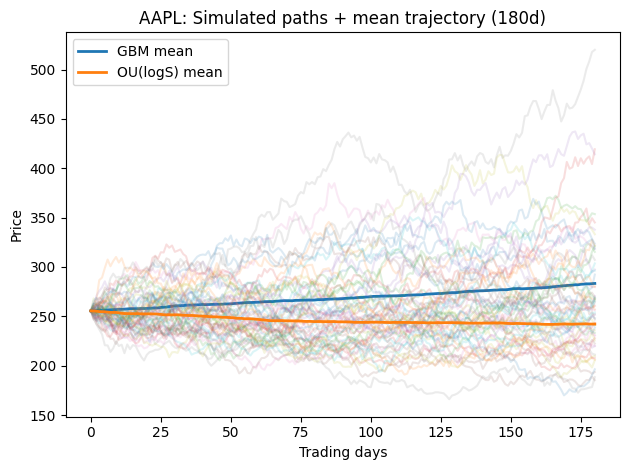

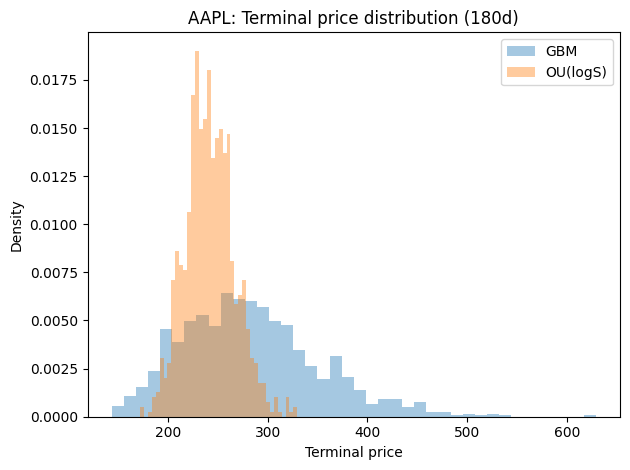

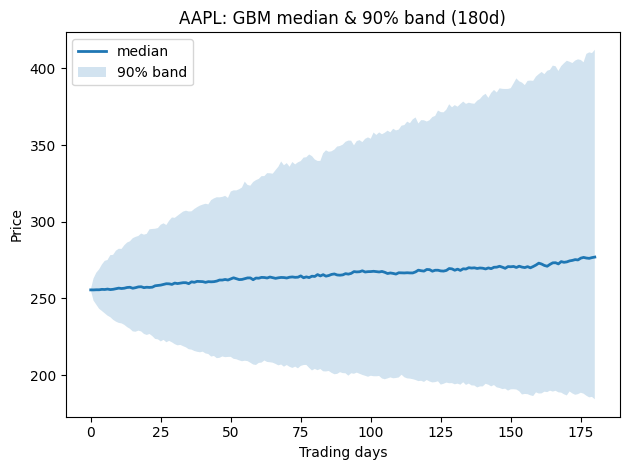

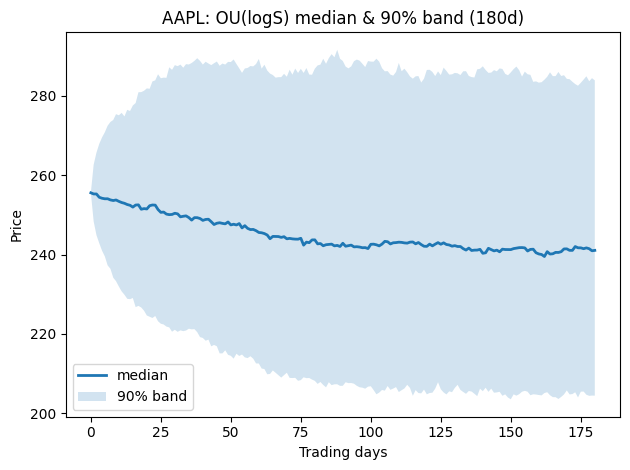



Ticker analyzed: AAPL
Last observed price (S0): 255.53
----------------------------------------------------------------------
Fitted model parameters:
  GBM  | annual drift (mu): 0.1373 | annual vol (sigma): 0.2795
  OU   | theta: 3.9050 | long-run mu (log): 5.4776 | annual sigma: 0.2809

Monte Carlo simulation results (terminal distribution):

Horizon: 30 trading days
  GBM:
    Mean: 260.52 | Median: 259.97 | 90% CI: [220.16, 302.51] | P(loss): 0.429
  OU (log-price):
    Mean: 251.55 | Median: 250.39 | 90% CI: [221.06, 287.66] | P(loss): 0.614



Horizon: 60 trading days
  GBM:
    Mean: 264.30 | Median: 263.15 | 90% CI: [207.92, 327.90] | P(loss): 0.428
  OU (log-price):
    Mean: 246.77 | Median: 245.55 | 90% CI: [212.57, 289.22] | P(loss): 0.672



Horizon: 180 trading days
  GBM:
    Mean: 283.29 | Median: 276.92 | 90% CI: [184.21, 412.11] | P(loss): 0.368
  OU (log-price):
    Mean: 242.17 | Median: 241.04 | 90% CI: [204.48, 283.84] | P(loss): 0.717



Interpretation hints:
-

,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,AAPL,30,GBM,260.524118,259.973376,220.158972,302.509637,0.429
1,AAPL,30,OU(logS),251.552930,250.387334,221.055325,287.664532,0.614
2,AAPL,60,GBM,264.304930,263.154498,207.915070,327.899692,0.428
3,AAPL,60,OU(logS),246.769814,245.549197,212.566899,289.216065,0.672
4,AAPL,180,GBM,283.291238,276.923581,184.207144,412.107016,0.368
5,AAPL,180,OU(logS),242.170363,241.041036,204.478830,283.835940,0.717


,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,AAPL,30,GBM,260.524118,259.973376,220.158972,302.509637,0.429
1,AAPL,30,OU(logS),251.552930,250.387334,221.055325,287.664532,0.614
2,AAPL,60,GBM,264.304930,263.154498,207.915070,327.899692,0.428
3,AAPL,60,OU(logS),246.769814,245.549197,212.566899,289.216065,0.672
4,AAPL,180,GBM,283.291238,276.923581,184.207144,412.107016,0.368
5,AAPL,180,OU(logS),242.170363,241.041036,204.478830,283.835940,0.717


In [86]:
summary_AAPL = analyze_one_ticker("AAPL")
summary_AAPL

## Results — MSFT

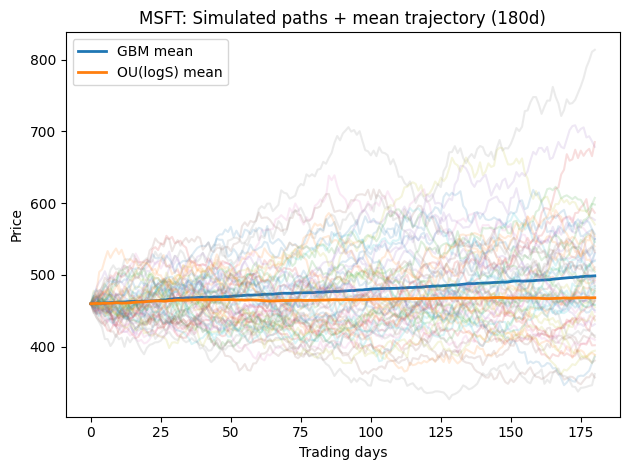

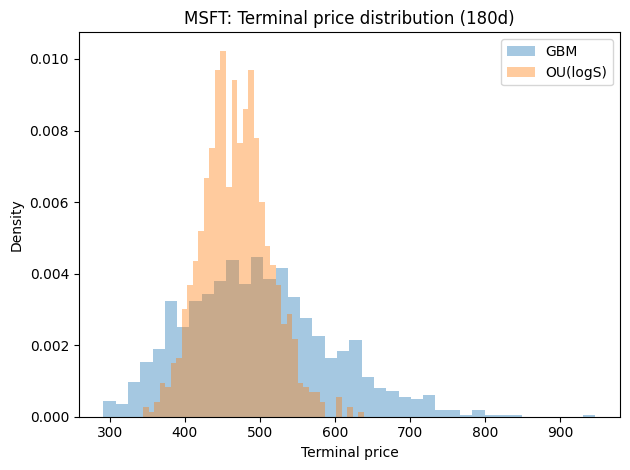

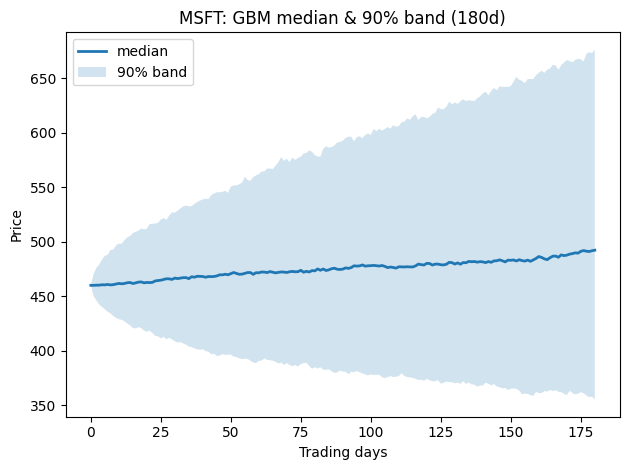

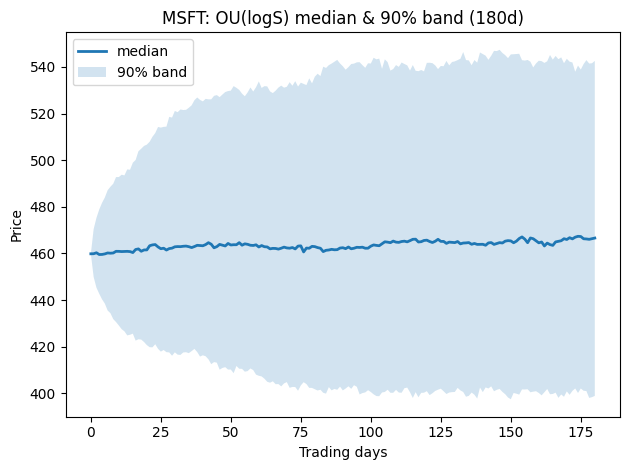



Ticker analyzed: MSFT
Last observed price (S0): 459.86
----------------------------------------------------------------------
Fitted model parameters:
  GBM  | annual drift (mu): 0.1083 | annual vol (sigma): 0.2232
  OU   | theta: 2.8445 | long-run mu (log): 6.1432 | annual sigma: 0.2240

Monte Carlo simulation results (terminal distribution):

Horizon: 30 trading days
  GBM:
    Mean: 466.95 | Median: 466.51 | 90% CI: [408.51, 526.52] | P(loss): 0.427
  OU (log-price):
    Mean: 464.66 | Median: 462.86 | 90% CI: [417.59, 521.12] | P(loss): 0.455



Horizon: 60 trading days
  GBM:
    Mean: 472.26 | Median: 471.33 | 90% CI: [390.49, 561.85] | P(loss): 0.423
  OU (log-price):
    Mean: 464.61 | Median: 462.78 | 90% CI: [407.54, 533.78] | P(loss): 0.467



Horizon: 180 trading days
  GBM:
    Mean: 498.74 | Median: 492.07 | 90% CI: [355.33, 675.94] | P(loss): 0.359
  OU (log-price):
    Mean: 468.17 | Median: 466.61 | 90% CI: [398.90, 542.59] | P(loss): 0.442



Interpretation hints:
-

,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,MSFT,30,GBM,466.948839,466.506384,408.512067,526.518379,0.427
1,MSFT,30,OU(logS),464.660243,462.855207,417.592698,521.115533,0.455
2,MSFT,60,GBM,472.262363,471.333829,390.492146,561.847891,0.423
3,MSFT,60,OU(logS),464.614985,462.778991,407.540783,533.778476,0.467
4,MSFT,180,GBM,498.743133,492.071731,355.331754,675.937003,0.359
5,MSFT,180,OU(logS),468.166522,466.610489,398.903190,542.588441,0.442


,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,MSFT,30,GBM,466.948839,466.506384,408.512067,526.518379,0.427
1,MSFT,30,OU(logS),464.660243,462.855207,417.592698,521.115533,0.455
2,MSFT,60,GBM,472.262363,471.333829,390.492146,561.847891,0.423
3,MSFT,60,OU(logS),464.614985,462.778991,407.540783,533.778476,0.467
4,MSFT,180,GBM,498.743133,492.071731,355.331754,675.937003,0.359
5,MSFT,180,OU(logS),468.166522,466.610489,398.903190,542.588441,0.442


In [87]:
summary_MSFT = analyze_one_ticker("MSFT")
summary_MSFT

## Results — NVDA

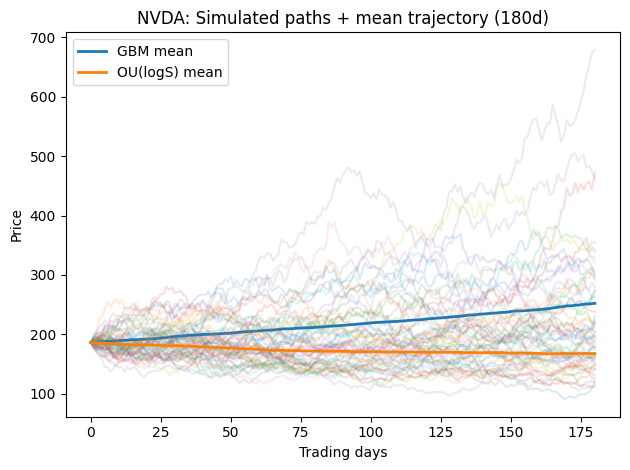

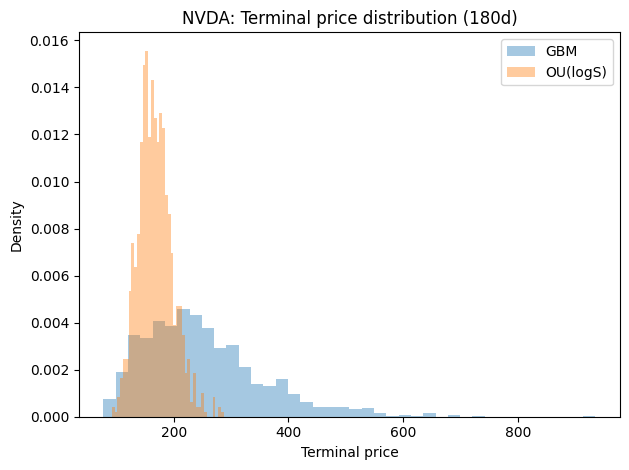

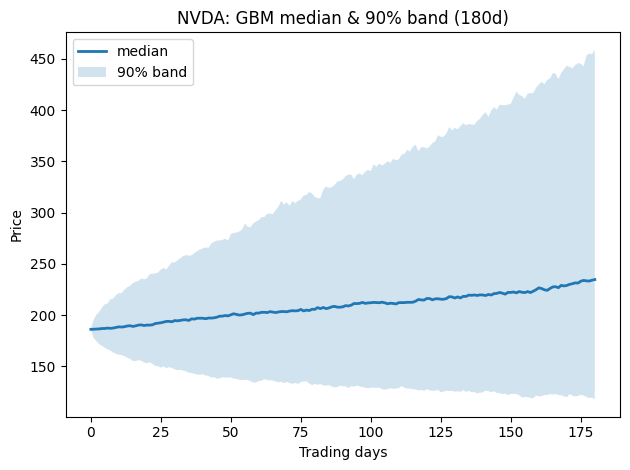

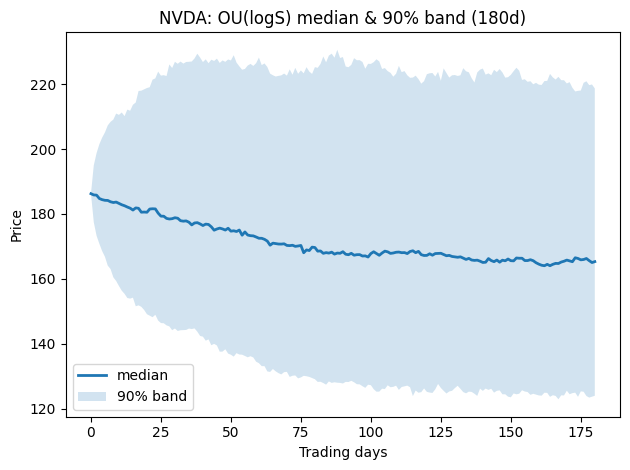



Ticker analyzed: NVDA
Last observed price (S0): 186.23
----------------------------------------------------------------------
Fitted model parameters:
  GBM  | annual drift (mu): 0.4107 | annual vol (sigma): 0.4710
  OU   | theta: 3.6213 | long-run mu (log): 5.0916 | annual sigma: 0.4730

Monte Carlo simulation results (terminal distribution):

Horizon: 30 trading days
  GBM:
    Mean: 196.55 | Median: 194.81 | 90% CI: [147.21, 251.49] | P(loss): 0.401
  OU (log-price):
    Mean: 180.96 | Median: 178.82 | 90% CI: [144.68, 226.87] | P(loss): 0.632



Horizon: 60 trading days
  GBM:
    Mean: 205.77 | Median: 202.05 | 90% CI: [135.83, 292.73] | P(loss): 0.381
  OU (log-price):
    Mean: 174.66 | Median: 172.50 | 90% CI: [134.00, 228.18] | P(loss): 0.704



Horizon: 180 trading days
  GBM:
    Mean: 252.22 | Median: 234.72 | 90% CI: [118.07, 458.71] | P(loss): 0.300
  OU (log-price):
    Mean: 167.75 | Median: 165.29 | 90% CI: [123.95, 218.65] | P(loss): 0.757



Interpretation hints:
-

,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,NVDA,30,GBM,196.546771,194.808804,147.208281,251.494298,0.401
1,NVDA,30,OU(logS),180.960509,178.820433,144.683313,226.873270,0.632
2,NVDA,60,GBM,205.766737,202.046347,135.827705,292.726286,0.381
3,NVDA,60,OU(logS),174.662373,172.497525,134.004387,228.182088,0.704
4,NVDA,180,GBM,252.224558,234.715786,118.067109,458.705919,0.300
5,NVDA,180,OU(logS),167.752663,165.294022,123.952986,218.650298,0.757


,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,NVDA,30,GBM,196.546771,194.808804,147.208281,251.494298,0.401
1,NVDA,30,OU(logS),180.960509,178.820433,144.683313,226.873270,0.632
2,NVDA,60,GBM,205.766737,202.046347,135.827705,292.726286,0.381
3,NVDA,60,OU(logS),174.662373,172.497525,134.004387,228.182088,0.704
4,NVDA,180,GBM,252.224558,234.715786,118.067109,458.705919,0.300
5,NVDA,180,OU(logS),167.752663,165.294022,123.952986,218.650298,0.757


In [88]:
summary_NVDA = analyze_one_ticker("NVDA")
summary_NVDA



---


## Cross‑Ticker Comparison (combined summary table)

In [89]:
all_summary = pd.concat([summary_AAPL, summary_MSFT, summary_NVDA], ignore_index=True)
all_summary


,Ticker,Horizon_days,Model,Mean,Median,P05,P95,Prob_Loss
0,AAPL,30,GBM,260.524118,259.973376,220.158972,302.509637,0.429
1,AAPL,30,OU(logS),251.552930,250.387334,221.055325,287.664532,0.614
2,AAPL,60,GBM,264.304930,263.154498,207.915070,327.899692,0.428
3,AAPL,60,OU(logS),246.769814,245.549197,212.566899,289.216065,0.672
4,AAPL,180,GBM,283.291238,276.923581,184.207144,412.107016,0.368
5,AAPL,180,OU(logS),242.170363,241.041036,204.478830,283.835940,0.717
6,MSFT,30,GBM,466.948839,466.506384,408.512067,526.518379,0.427
7,MSFT,30,OU(logS),464.660243,462.855207,417.592698,521.115533,0.455
8,MSFT,60,GBM,472.262363,471.333829,390.492146,561.847891,0.423
9,MSFT,60,OU(logS),464.614985,462.778991,407.540783,533.778476,0.467
